In [20]:
# import api kaggle
from google.colab import files
uploaded=files.upload()

!rm -rf ~/.kaggle && mkdir ~/.kaggle/
!mv kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [21]:
# download dataset
!kaggle datasets download -d fedesoriano/stroke-prediction-dataset

stroke-prediction-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [22]:
!unzip /content/stroke-prediction-dataset.zip

Archive:  /content/stroke-prediction-dataset.zip
replace healthcare-dataset-stroke-data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


#import library

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree  import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

#data frame

In [24]:
# Membaca file csv
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [25]:
# menghapus id
df = df.drop(['id'], axis=1)

In [26]:
# cek jumlah dataframe
df.shape

(5110, 11)

In [27]:
# cek informasi tentang dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [28]:
# mengubah tipe data int ke object
df['hypertension'] = df['hypertension'].astype('object')
df['heart_disease'] = df['heart_disease'].astype('object')

# mengubah tipe data stroke dari int ke object karena class target 
df['stroke'] = df['stroke'].astype('object')

df.stroke.replace(0,'Tidak mengalami Stroke', inplace=True)
df.stroke.replace(1,'Mengalami Stroke', inplace=True)

In [29]:
# Mendeskripsikan statistik
df.describe()

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,4909.000000
mean,43.226614,106.147677,28.893237
std,22.612647,45.283560,7.854067
min,0.080000,55.120000,10.300000
25%,25.000000,77.245000,23.500000
50%,45.000000,91.885000,28.100000
75%,61.000000,114.090000,33.100000
max,82.000000,271.740000,97.600000


In [30]:
# mengecek informasi yang di mmuat pada dataset
def report(df):
  col = []
  d_type = []
  uniques = []
  n_uniques = []

  for i in df.columns:
    col.append(i) 
    d_type.append(df[i].dtypes) 
    uniques.append(df[i].unique()[:5]) 
    n_uniques.append(df[i].nunique()) 

  return pd.DataFrame({'Column': col, 'd_type':d_type, 'unique_sample':uniques, 'n_unique_sample':n_uniques})

In [31]:
report(df)

,Column,d_type,unique_sample,n_unique_sample
0,gender,object,"[Male, Female, Other]",3
1,age,float64,"[67.0, 61.0, 80.0, 49.0, 79.0]",104
2,hypertension,object,"[0, 1]",2
3,heart_disease,object,"[1, 0]",2
4,ever_married,object,"[Yes, No]",2
5,work_type,object,"[Private, Self-employed, Govt_job, children, N...",5
6,Residence_type,object,"[Urban, Rural]",2
7,avg_glucose_level,float64,"[228.69, 202.21, 105.92, 171.23, 174.12]",3979
8,bmi,float64,"[36.6, nan, 32.5, 34.4, 24.0]",418
9,smoking_status,object,"[formerly smoked, never smoked, smokes, Unknown]",4


#menghilangkan missing value

In [32]:
# cek missing value
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [33]:
# Mengreplace missing value pada BMI
df.bmi = df.bmi.fillna(df.bmi.mean())
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,Mengalami Stroke
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,Mengalami Stroke
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,Mengalami Stroke
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,Mengalami Stroke
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,Mengalami Stroke


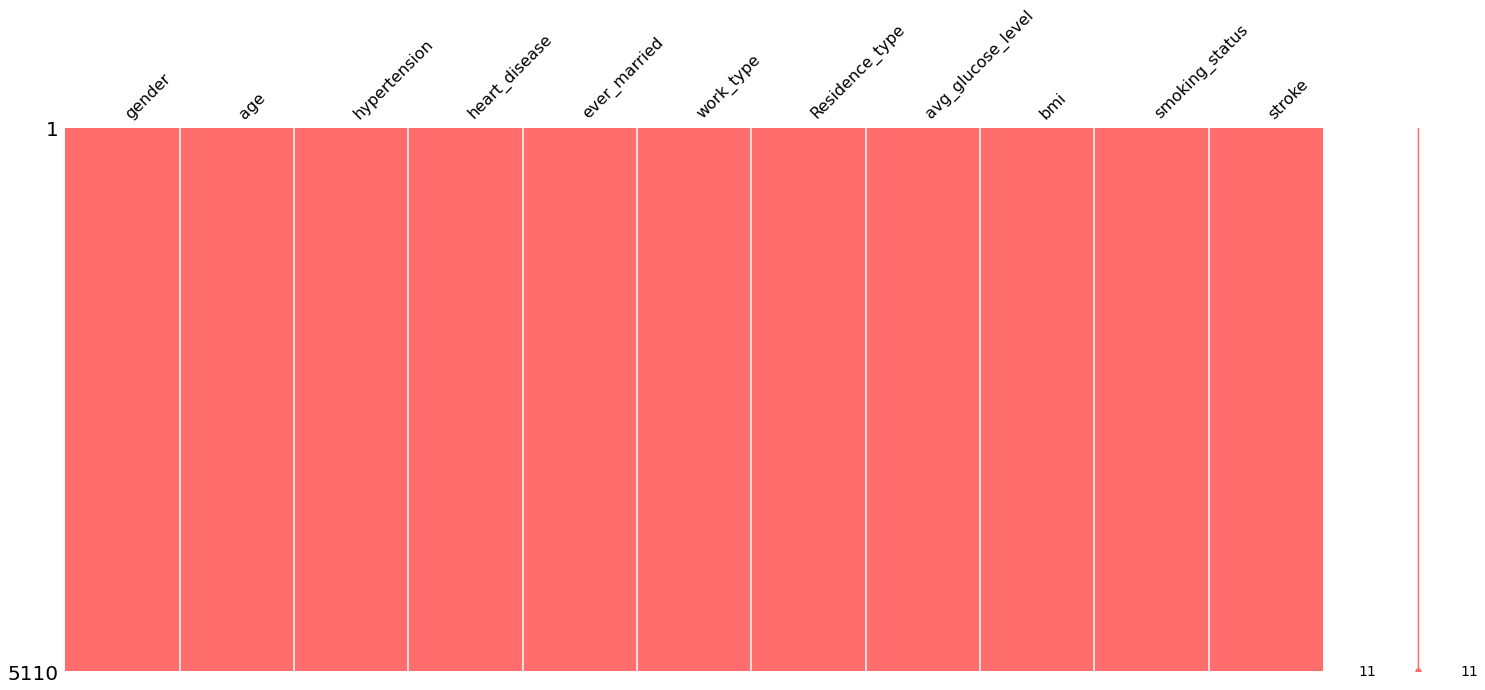

In [34]:
# Melakukan visualisasi data yang kosong
import missingno as msno
sorted_null = msno.nullity_sort(df, sort='descending') 
figures = msno.matrix(sorted_null, color=(1, 0.43, 0.43))

#univariat analysis

In [35]:
#membagi fitur pada dataset 
cat_features = ["gender", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type",
                "smoking_status","stroke"]
numerical_features = ["age", "avg_glucose_level", "bmi"]

        Total   Persentase
Female    2994        58.6
Male      2115        41.4
Other        1         0.0



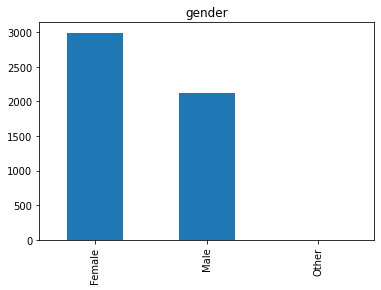

   Total   Persentase
0    4612        90.3
1     498         9.7



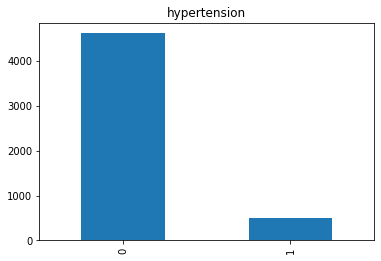

   Total   Persentase
0    4834        94.6
1     276         5.4



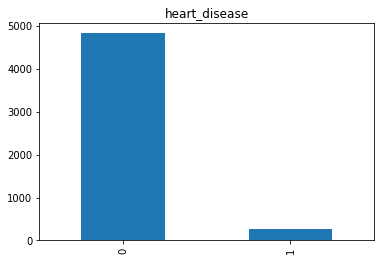

     Total   Persentase
Yes    3353        65.6
No     1757        34.4



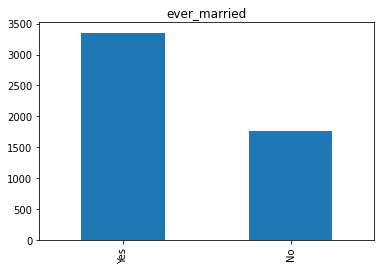

               Total   Persentase
Private          2925        57.2
Self-employed     819        16.0
children          687        13.4
Govt_job          657        12.9
Never_worked       22         0.4



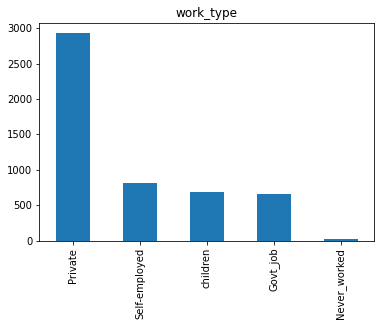

       Total   Persentase
Urban    2596        50.8
Rural    2514        49.2



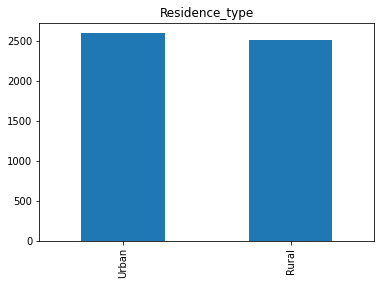

                 Total   Persentase
never smoked       1892        37.0
Unknown            1544        30.2
formerly smoked     885        17.3
smokes              789        15.4



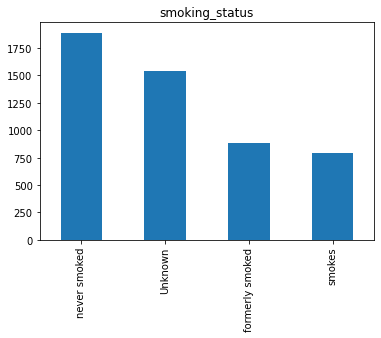

                        Total   Persentase
Tidak mengalami Stroke    4861        95.1
Mengalami Stroke           249         4.9



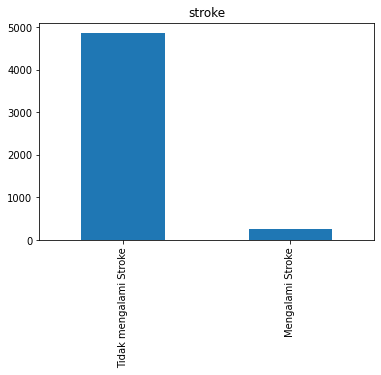

In [36]:
#melihar kategori fitur kategori
for column in cat_features:
    count = df[column].value_counts()
    percent = 100*df[column].value_counts(normalize=True)
    data_baru = pd.DataFrame({'Total ':count, 'Persentase':percent.round(1)})
    print(data_baru, end="\n\n")
    count.plot(kind='bar', title=column)
    plt.show()

#menganalisis outliers

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


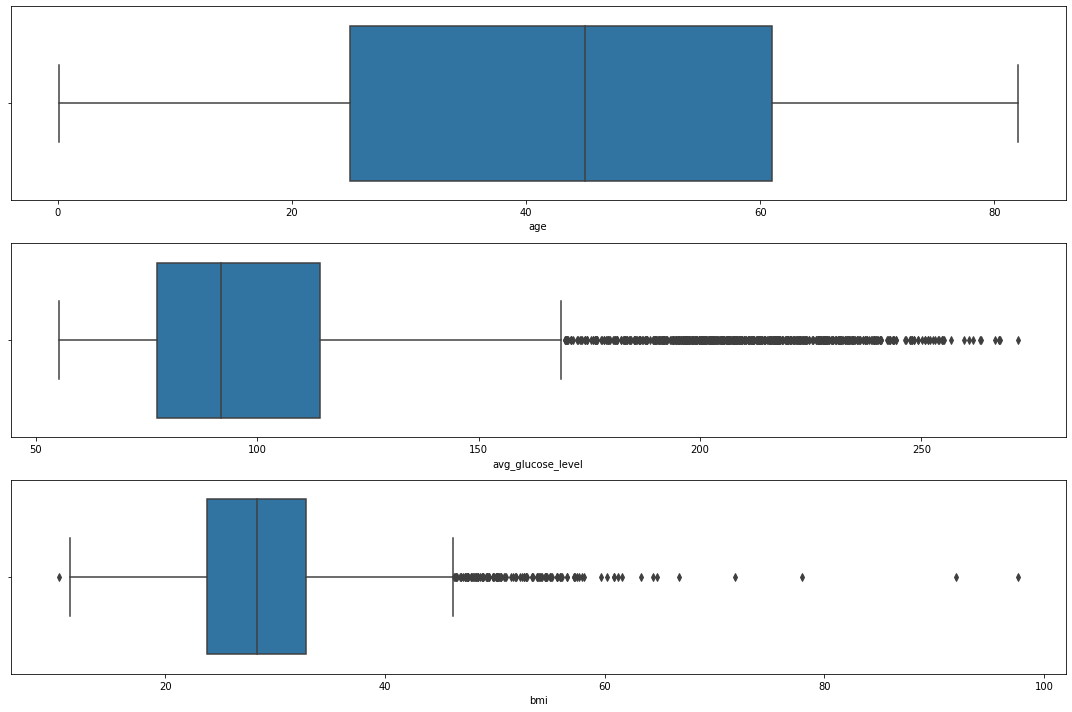

In [37]:
# melihat outlier pada numeric fitur
fig, axs = plt.subplots(len(numerical_features), figsize= (15,10))
i=0
for feature in numerical_features:
  sns.boxplot(df[feature], ax=axs[i])
  i+=1
  plt.tight_layout()
plt.show()

In [38]:
# menghapus outliers menggunakan IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR=Q3-Q1
df=df[~((df<(Q1-1.5*IQR))|(df>(Q3+1.5*IQR))).any(axis=1)]
 
# Cek ukuran dataset setelah kita drop outliers
df.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  """


(4391, 11)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


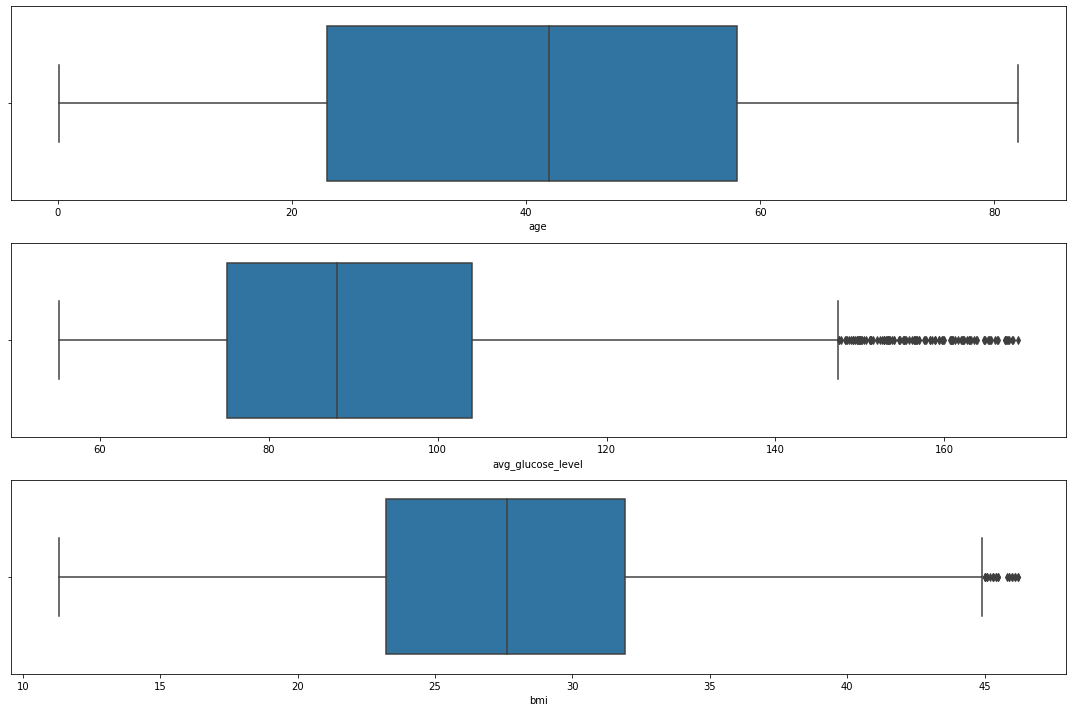

In [39]:
#hasil sesudah di drop outlier menggunakan IQR
fig, axs = plt.subplots(len(numerical_features), figsize= (15,10))
i=0
for feature in numerical_features:
  sns.boxplot(df[feature], ax=axs[i])
  i+=1
  plt.tight_layout()
plt.show()

#fitur numerik

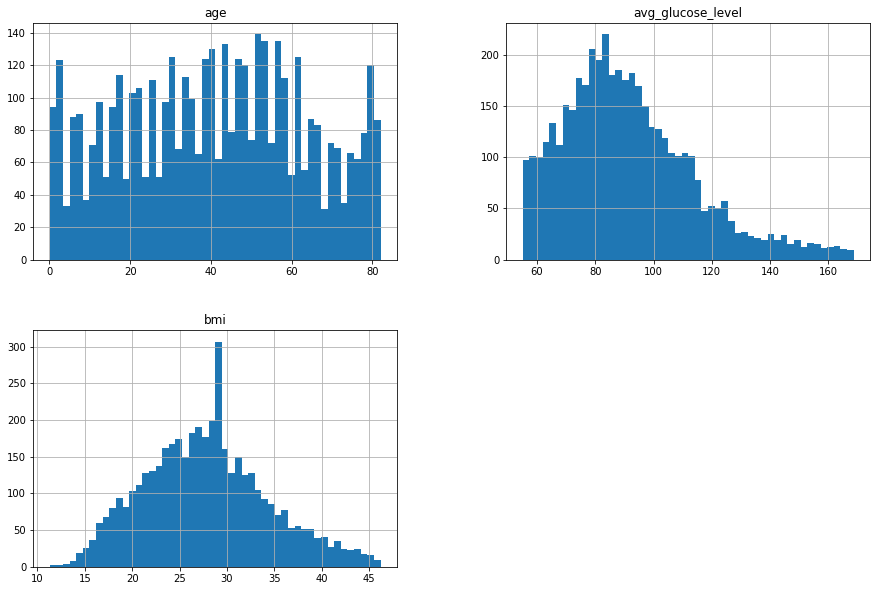

In [40]:
# melihat numerik fitur
df.hist(bins=50, figsize=(15,10))
plt.show()

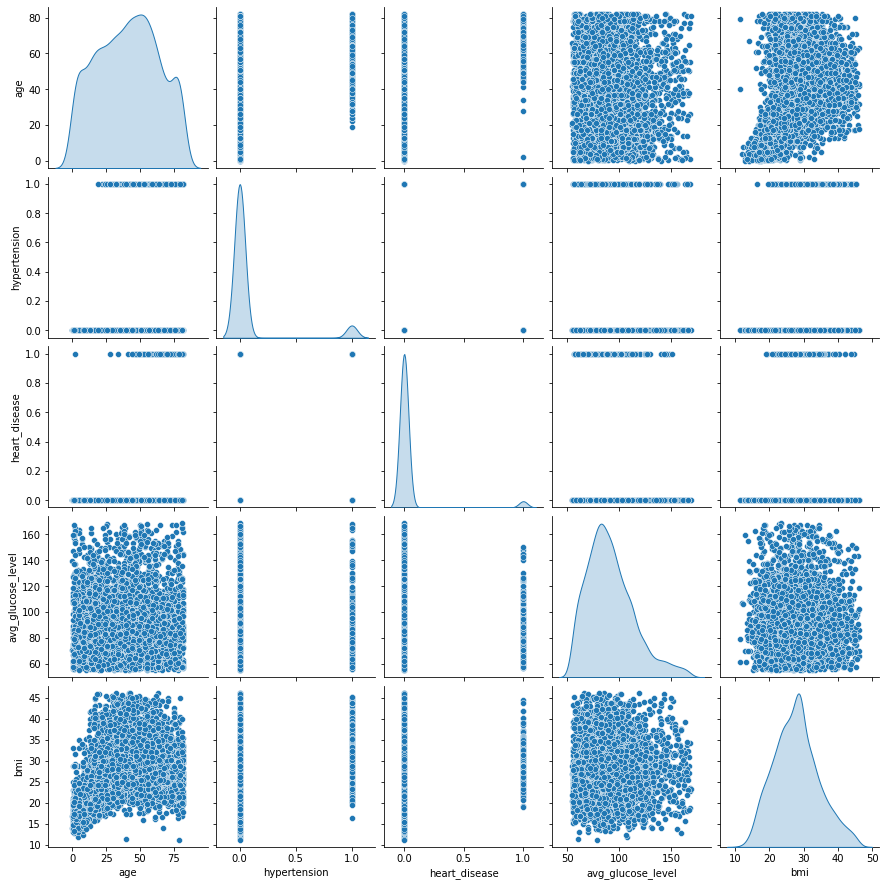

In [41]:
# Mengamati hubungan antar fitur numerik dengan fungsi pairplot()
sns.pairplot(df, diag_kind = 'kde')

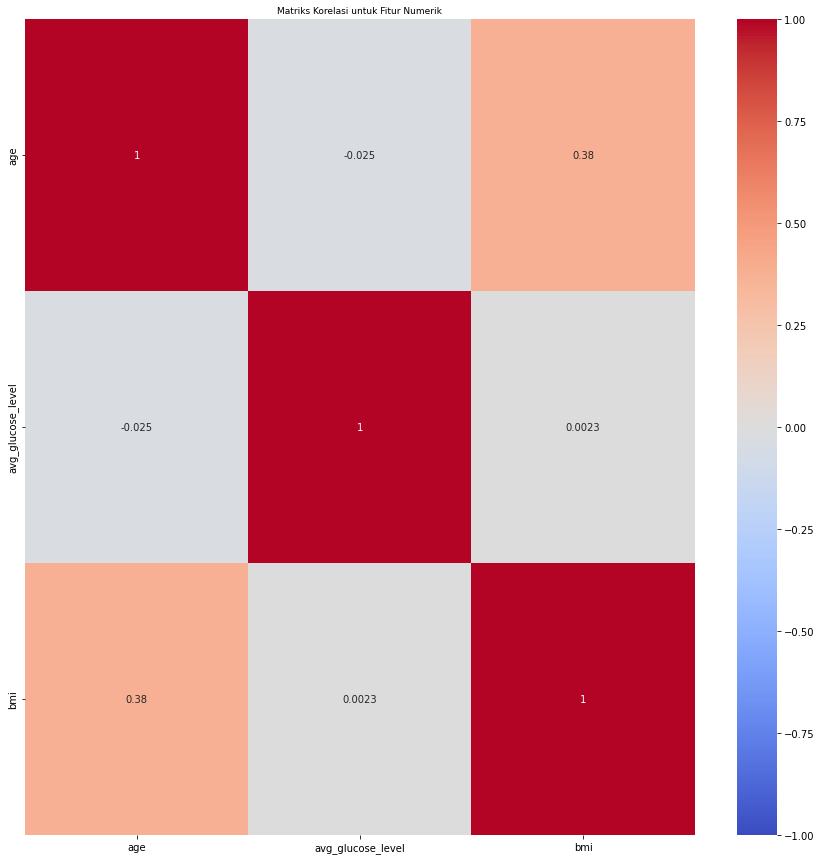

In [42]:
#evaluasi skor korelasi
plt.figure(figsize=(15,15))
plt.title('Matriks Korelasi untuk Fitur Numerik', fontsize=9)
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

#Data Preparation

In [43]:
# Encoding tanpa variabel dependent sebagai variabel target
df = pd.get_dummies(df, columns=df.loc[:, (df.dtypes == 'object') & (df.columns != 'stroke')].columns.to_list())

# hasil setelah encoding
df

,age,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,hypertension_0,hypertension_1,heart_disease_0,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
2,80.0,105.92,32.500000,Mengalami Stroke,0,1,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
6,74.0,70.09,27.400000,Mengalami Stroke,0,1,0,0,1,0,...,0,1,0,0,1,0,0,0,1,0
7,69.0,94.39,22.800000,Mengalami Stroke,1,0,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0
8,59.0,76.15,28.893237,Mengalami Stroke,1,0,0,1,0,1,...,0,1,0,0,1,0,1,0,0,0
9,78.0,58.57,24.200000,Mengalami Stroke,1,0,0,1,0,1,...,0,1,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,80.0,83.75,28.893237,Tidak mengalami Stroke,1,0,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
5106,81.0,125.20,40.000000,Tidak mengalami Stroke,1,0,0,1,0,1,...,0,0,1,0,0,1,0,0,1,0
5107,35.0,82.99,30.600000,Tidak mengalami Stroke,1,0,0,1,0,1,...,0,0,1,0,1,0,0,0,1,0
5108,51.0,166.29,25.600000,Tidak mengalami Stroke,0,1,0,1,0,1,...,0,1,0,0,1,0,0,1,0,0


In [44]:
# Split data
X = df.drop(["stroke"],axis =1)
y = df["stroke"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 123)

# hasil split data
print(f'Total # of sample in whole dataset: {len(X)}')
print(f'Total # of sample in train dataset: {len(X_train)}')
print(f'Total # of sample in test dataset: {len(X_test)}')

Total # of sample in whole dataset: 4391
Total # of sample in train dataset: 3951
Total # of sample in test dataset: 440


#standarisasi

In [45]:
# melakukan standarisasi
numerical_features = ["age", "avg_glucose_level", "bmi"]
scaler = StandardScaler()
scaler.fit(X_train[numerical_features])
X_train[numerical_features] = scaler.transform(X_train.loc[:, numerical_features])
X_train[numerical_features].head()

,age,avg_glucose_level,bmi
2806,0.660139,-0.411849,0.717537
3660,0.483569,-1.066727,1.297762
1740,-0.134424,2.054768,2.137562
5068,1.719557,1.263347,-0.534527
26,1.057421,0.421551,0.060967


In [46]:
#mengubah rata-rata mean
X_train[numerical_features].describe().round(4)

,age,avg_glucose_level,bmi
count,3951.0000,3951.0000,3951.0000
mean,-0.0000,-0.0000,0.0000
std,1.0001,1.0001,1.0001
min,-1.8083,-1.6049,-2.5195
25%,-0.7966,-0.7223,-0.7025
50%,0.0421,-0.1476,-0.0154
75%,0.7926,0.5541,0.6259
max,1.8078,3.4131,2.8094


#model development

random forest

In [47]:
# pemodelan menggunakan classification with random forest

rf = RandomForestClassifier(n_estimators = 100, criterion= 'entropy', random_state = 0)
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=0)

In [48]:
#cek akurasi random forest
y_pred_train_rf = rf.predict(X_train)
acc_train_rf = accuracy_score(y_train, y_pred_train_rf)

y_pred_test_rf = rf.predict(X_test)
acc_test_rf = accuracy_score(y_test, y_pred_test_rf)
print(acc_train_rf)
print(acc_test_rf)

0.9997468995191091
0.9727272727272728


In [49]:
# report klasifikasi untuk model random forest
Random_Forest = classification_report(y_test, y_pred_test_rf, output_dict=True)
pd.DataFrame(Random_Forest)

,Mengalami Stroke,Tidak mengalami Stroke,accuracy,macro avg,weighted avg
precision,1.000000,0.972665,0.972727,0.986333,0.973473
recall,0.076923,1.000000,0.972727,0.538462,0.972727
f1-score,0.142857,0.986143,0.972727,0.564500,0.961228
support,13.000000,427.000000,0.972727,440.000000,440.000000


decision tree

In [50]:
#pemodelan menggunakan Decision Tree
dt =DecisionTreeClassifier(max_features=14 , max_depth=12, criterion= 'gini')
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=12, max_features=14)

In [51]:
#cek akurasi model decision tree
y_pred_train_dt = dt.predict(X_train)
acc_train_dt = accuracy_score(y_train, y_pred_train_dt)

y_pred_test_dt = dt.predict(X_test)
acc_test_dt = accuracy_score(y_test, y_pred_test_dt)
print(acc_train_dt)
print(acc_test_dt)

0.9893697798025817
0.17045454545454544


In [52]:
# report klasifikasi untuk model decision tree
Decision_tree = classification_report(y_test, y_pred_test_dt, output_dict=True)
pd.DataFrame(Decision_tree)

,Mengalami Stroke,Tidak mengalami Stroke,accuracy,macro avg,weighted avg
precision,0.024324,0.942857,0.170455,0.483591,0.915719
recall,0.692308,0.154567,0.170455,0.423437,0.170455
f1-score,0.046997,0.265594,0.170455,0.156295,0.259135
support,13.000000,427.000000,0.170455,440.000000,440.000000


In [53]:
# Lakukan scaling terhadap fitur numerik pada X_test sehingga memiliki rata-rata=0 dan varians=1
X_test.loc[:, numerical_features] = scaler.transform(X_test[numerical_features])

#evaluasi

In [54]:
print("Classification Report untuk Model random forest")
pd.DataFrame(Random_Forest)

Classification Report untuk Model random forest


,Mengalami Stroke,Tidak mengalami Stroke,accuracy,macro avg,weighted avg
precision,1.000000,0.972665,0.972727,0.986333,0.973473
recall,0.076923,1.000000,0.972727,0.538462,0.972727
f1-score,0.142857,0.986143,0.972727,0.564500,0.961228
support,13.000000,427.000000,0.972727,440.000000,440.000000


In [55]:
print("Classification Report untuk Model decision tree")
pd.DataFrame(Decision_tree)

Classification Report untuk Model decision tree


,Mengalami Stroke,Tidak mengalami Stroke,accuracy,macro avg,weighted avg
precision,0.024324,0.942857,0.170455,0.483591,0.915719
recall,0.692308,0.154567,0.170455,0.423437,0.170455
f1-score,0.046997,0.265594,0.170455,0.156295,0.259135
support,13.000000,427.000000,0.170455,440.000000,440.000000
